# Squeeze and Excitation Network (SENet)

---

## 目的
SENetの構造を理解する.

SENetを用いてCIFAR-10データセットに対する物体認識を行う．

## Squeeze and Excitation Network (SENet)

SENetとは，ILSVRC2017で優勝したモデルであり，認識に有益なチャネルに対して重み付けすることで認識精度の高精度化を実現しました．SENet は，特徴マップにGlobal Average Pooling (GAP) を施し，$1×1$の畳み込み処理を行うことで各チャネルに対する重みを獲得します．その後，特徴マップの各チャネルごとに重み付けを行います．これにより，認識に有益なチャネルに対して重点的に学習することができます．
SENetは汎用性が高く，従来のあらゆるモデル (e.g., VGG, ResNet) に導入することができます．

<img src="https://www.dropbox.com/s/u8btdc5cfu8dq03/senet.png?dl=1" width=100%>




## モジュールのインポート
プログラムの実行に必要なモジュールをインポートします．
今回は，機械学習ライブラリであるPytorchを使用します．
PyTorchとは，Python向けのオープンソース機械学習ライブラリで，Facebookに開発されました．

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torchsummary

## GPUの確認
GPUを使用した計算が可能かどうかを確認します．
下記のコードを実行してGPU情報を確認します． GPUの確認を行うためには，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．

`Use CUDA: True`と表示されれば，GPUを使用した計算をPytorchで行うことが可能です． CPUとなっている場合は，上記に記載している手順にしたがって，設定を変更してください．

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_cuda = torch.cuda.is_available()
cudnn.benchmark = True
print('Use CUDA:', use_cuda)

Use CUDA: True


下記のコードを実行してGPU情報を確認します．



In [ ]:
!nvidia-smi

Sun Aug 23 16:28:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W /  70W |   1495MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 使用するデータセット

### データセット
今回の物体認識では，CIFAR-10データセットを使用します．CIFAR-10データセットは，飛行機や犬などの10クラスの物体が表示されている画像から構成されたデータセットです．

![CIFAR10_sample.png](https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/176458/b6b43478-c85f-9211-7bc6-227d9b387af5.png)

### データセットのダウンロードと読み込み
実験に使用するCIFAR-10データセットを読み込みます．
１回の誤差を算出するデータ数 (ミニバッチサイズ) は，256とします．
まず，CIFAR-10データセットをダウンロードします．
次に，ダウンロードしたデータセットを読み込みます．
学習には，大量のデータを利用しますが，それでも十分ではありません． そこで，データ拡張 (data augmentation) により，データのバリエーションを増やします． 一般的な方法は，画像の左右反転，明るさ変換などです．

In [ ]:
batch_size = 256

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=20)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=20)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### CIFAR-10データセットの表示
CIFAR-10データセットに含まれる画像を表示してみます．
ここでは，matplotlibを用いて複数の画像を表示させるプログラムを利用します．
学習データは5万枚，1つのデータサイズは3x32x32の画像のような形式となっています． これは32x32ピクセルのカラー画像という意味になります．



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


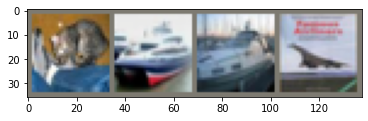

  cat  ship  ship plane


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    npimg = ((npimg.transpose((1,2,0))  * [0.2023, 0.1994, 0.2010]) + [0.4914, 0.4822, 0.4465])  # unnormalize
    plt.imshow(npimg)
    plt.show()

# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## ネットワークモデルの定義
次に，SENetを定義します．
今回は，ResNetにSENetを導入したモデル (SE-ResNet) を使用します．SE-ResNetの層の深さ (depth) は，110層に設定します．

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import math

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

        """
        if planes == 16:
            self.globalAvgPool = nn.AvgPool2d(32, stride=1)
        elif planes == 32:
            self.globalAvgPool = nn.AvgPool2d(16, stride=1)
        elif planes == 64:
            if down_size:
                self.globalAvgPool = nn.AvgPool2d(8, stride=1)
            else:
                self.globalAvgPool = nn.AvgPool2d(16, stride=1)
        """
        self.globalAvgPool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_features=planes, out_features=planes // 4)
        self.fc2 = nn.Linear(in_features=planes // 4, out_features=planes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        # SE Block
        original_out = out
        out = self.globalAvgPool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = out.view(out.size(0), out.size(1), 1, 1)
        out = out * original_out
        #out = out + original_out

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        """
        if planes == 64:
            self.globalAvgPool = nn.AvgPool2d(56, stride=1)
        elif planes == 128:
            self.globalAvgPool = nn.AvgPool2d(28, stride=1)
        elif planes == 256:
            self.globalAvgPool = nn.AvgPool2d(14, stride=1)
        elif planes == 512:
            if down_size:
                self.globalAvgPool = nn.AvgPool2d(7, stride=1)
            else:
                self.globalAvgPool = nn.AvgPool2d(14, stride=1)
        """
        self.globalAvgPool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_features=planes * 4, out_features=planes * 4 // 16)
        self.fc2 = nn.Linear(in_features=planes * 4 // 16, out_features=planes * 4)
        self.sigmoid = nn.Sigmoid()
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        # SE Block
        original_out = out
        out = self.globalAvgPool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = out.view(out.size(0),out.size(1),1,1)
        out = out * original_out
        #out = out + original_out

        out += residual
        out = self.relu(out)

        return out


class SE_ResNet(nn.Module):

    def __init__(self, depth, num_classes=10):
        super(SE_ResNet, self).__init__()
        # Model type specifies number of layers for CIFAR-10 model
        block_name = 'Bottleneck' if depth >=44 else 'BasicBlock'
        if block_name.lower() == 'basicblock':
            assert (depth - 2) % 6 == 0, 'When use basicblock, depth should be 6n+2, e.g. 20, 32, 44'
            n = (depth - 2) // 6
            block = BasicBlock
        elif block_name.lower() == 'bottleneck':
            assert (depth - 2) % 9 == 0, 'When use bottleneck, depth should be 9n+2, e.g. 47, 56, 110, 1199'
            n = (depth - 2) // 9
            block = Bottleneck
        else:
            raise ValueError('block_name shoule be Basicblock or Bottleneck')

        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, n)
        self.layer2 = self._make_layer(block, 32, n, stride=2)
        self.layer3 = self._make_layer(block, 64, n, stride=2)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)    # 32x32

        x = self.layer1(x)  # 32x32
        x = self.layer2(x)  # 16x16
        x = self.layer3(x)  # 8x8

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

depth = 20 # e.g. 20, 32, 44, 47, 56, 110, 1199
model = SE_ResNet(depth)
model.to(device)

SE_ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (globalAvgPool): AdaptiveAvgPool2d(output_size=1)
      (fc1): Linear(in_features=16, out_features=4, bias=True)
      (fc2): Linear(in_features=4, out_features=16, bias=True)
      (sigmoid): Sigmoid()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

## 損失関数と最適化手法の定義
学習に使用する損失関数と最適化手法を定義します．
`scheduler`で学習率のスケジューリングを行います．
`scheduler`では，初期の学習率を0.1に設定し，全体のエポック数の1/2と3/4で学習率を0.1倍します．
各更新において，学習用データと教師データをそれぞれ`inputs`と`targets`とします．
学習モデルに`inputs`を与えて，SENetの出力を取得します．
SENetの出力と教師ラベル`targets`との誤差を`criterion`で算出します．
また，認識精度も算出します．
そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．
最適化手法には，確率的勾配降下法 (stochastic gradient descent: SGD) を用いて学習します．

最後に，定義したネットワークの詳細情報を`torchsummary.summary()`関数を用いて表示します．

In [ ]:
import torch.optim as optim
from torch.optim import SGD, lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1) # 50 < 75

# モデルの情報を表示
torchsummary.summary(model, (3, 32, 32))

## 学習
学習エポック数を100とします．
CIFAR-10の学習データサイズを取得し，1エポック内における更新回数を求めます．
1エポック学習するごとに学習したモデルを評価し，最も精度の高いモデルが保存されます．

In [ ]:
epochs = 100
best_acc = 0  # best test accuracy

# Training
for epoch in range(epochs):
    scheduler.step()
    train_running_loss = 0.0
    train_running_acc = 0.0

    # training
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    count = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()


        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # print statistics
        train_running_loss += loss
        train_running_acc += 100.*correct/total
        count += 1

    print('[Epoch %d] Train Loss: %.5f | Train Acc: %.3f%%'
                  % (epoch + 1, train_loss/count, train_running_acc/count))
    
    # testing
    model.eval() 
    with torch.no_grad():
        test_running_loss = 0.0
        test_running_acc = 0.0
        test_loss = 0
        correct = 0
        total = 0
        count = 0
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # print statistics
            test_running_loss += loss
            test_running_acc += 100.*correct/total
            count += 1

        print('Test Loss: %.5f | Test Acc: %.3f%%'
                      % (test_loss/count, test_running_acc/count))
        
    # save model
    if test_running_acc/count > best_acc:
        best_acc = max(test_running_acc/count, best_acc)
        PATH = './cifar_net.pth'
        torch.save(model.state_dict(), PATH)
    
print('Finished Training')

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[Epoch 1] Train Loss: 1.64972 | Train Acc: 28.988%
Test Loss: 1.45358 | Test Acc: 48.213%
[Epoch 2] Train Loss: 1.17172 | Train Acc: 54.107%
Test Loss: 1.17734 | Test Acc: 56.919%
[Epoch 3] Train Loss: 0.95358 | Train Acc: 64.312%
Test Loss: 1.50504 | Test Acc: 52.415%
[Epoch 4] Train Loss: 0.82157 | Train Acc: 69.582%
Test Loss: 0.91721 | Test Acc: 69.001%
[Epoch 5] Train Loss: 0.71727 | Train Acc: 74.566%
Test Loss: 0.78993 | Test Acc: 73.323%
[Epoch 6] Train Loss: 0.65389 | Train Acc: 76.677%
Test Loss: 0.73123 | Test Acc: 75.927%
[Epoch 7] Train Loss: 0.61752 | Train Acc: 78.083%
Test Loss: 0.75942 | Test Acc: 74.838%
[Epoch 8] Train Loss: 0.57687 | Train Acc: 79.745%
Test Loss: 0.89822 | Test Acc: 70.149%
[Epoch 9] Train Loss: 0.55123 | Train Acc: 81.037%
Test Loss: 0.56641 | Test Acc: 80.955%
[Epoch 10] Train Loss: 0.53182 | Train Acc: 81.347%
Test Loss: 0.68215 | Test Acc: 76.573%
[Epoch 11] Train Loss: 0.51403 | Train Acc: 82.193%
Test Loss: 0.73936 | Test Acc: 76.059%
[Epoch 1

##テスト
学習したネットワークのテストデータに対する認識率の確認を行います．まず，学習したネットワークを評価するために保存したモデルをロードします．

In [ ]:
depth = 20 #e.g. 20, 32, 44, 47, 56, 110, 1199
model = SE_ResNet(depth)
model.to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

次に，学習したネットワークを用いて，テストデータに対する認識率の確認を行います．
`model.eval()`を適用することで，ネットワーク演算を評価モードへ変更します． これにより，学習時と評価時で挙動が異なる演算（dropout等）を変更することが可能です． また，`torch.no_grad()`を適用することで，学習時には必要になる勾配情報を保持することなく演算を行います．

In [ ]:
# testing
model.eval() 
with torch.no_grad():
    test_running_loss = 0.0
    test_running_acc = 0.0
    test_loss = 0
    correct = 0
    total = 0
    count = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # print statistics
        test_running_loss += loss
        test_running_acc += 100.*correct/total
        count += 1

    print('Test Loss: %.5f | Test Acc: %.3f%%'
                  % (test_loss/count, test_running_acc/count))

Test Loss: 0.24143 | Test Acc: 93.304%


## 課題
1. エポック数やミニバッチサイズを変えて実験しましょう．

In [ ]:
#ここにコードを書く

2. SE-ResNetの層数を変えて精度の変化を比較しましょう．

In [ ]:
#ここにコードを書く